In [42]:
from BenchmarkProblems.Trapk import Trapk
import numpy as np

import utils
from BenchmarkProblems.ToyAmalgam import ToyAmalgam
from BenchmarkProblems.OneMax import OneMax
import itertools

from BenchmarkProblems.RoyalRoad import RoyalRoad
from Core.get_pRef import get_pRef_from_metaheuristic

problem = RoyalRoad(5)

pRef = get_pRef_from_metaheuristic(problem=problem,
                                   sample_size=10000,
                                   which_algorithm="uniform",
                                   unique=True)

best_solution = pRef.get_best_solution()
print(pRef)

PRef with 9956 samples, mean = 1.25


In [55]:
from Core.FullSolution import FullSolution
from Core.SearchSpace import SearchSpace
import numpy as np

def every_var(search_space):
    return range(search_space.amount_of_parameters)

def every_pair_of_vars(search_space):
    return itertools.combinations(range(search_space.amount_of_parameters), r=2)

def every_value_for_var(var, search_space):
    return range(search_space.cardinalities[var])


def get_mutual_information_from_dicts(univariate_freq_dict, bivariate_freq_dict, search_space: SearchSpace):
    
    def mutual_information_for_values(a, b, va, vb):
        p_ab = bivariate_freq_dict[(a, b, va, vb)]
        p_a = univariate_freq_dict[(a, va)]
        p_b = univariate_freq_dict[(b, vb)]
        if p_ab == 0:
            return 0
        return p_ab * np.log(p_ab / (p_a * p_b))
    
    value_specific_mis = {(a, b, va, vb): mutual_information_for_values(a, b, va, vb)
                          for a, b in every_pair_of_vars(search_space)
                          for va in every_value_for_var(a, search_space)
                          for vb in every_value_for_var(b, search_space)
                          }
    
    def mutual_information_for_variable_pair(a, b):
        return sum(np.abs(value_specific_mis[(a, b, va, vb)])
                   for va in every_value_for_var(a, search_space)
                   for vb in every_value_for_var(b, search_space))
    
    variable_mis = {(a, b): mutual_information_for_variable_pair(a, b) 
                    for a, b in every_pair_of_vars(search_space)}
    
    return value_specific_mis, variable_mis


def complete_linkage_table(linkage_table):
    n = linkage_table.shape[0]
    new_table = linkage_table + linkage_table.T
    sums_of_linkages = np.sum(new_table, axis=0)
    averages = sums_of_linkages / (n - 1)
    np.fill_diagonal(new_table, averages)
    return new_table


def linkage_table_from_mi_dict_for_vars(variable_mis, search_space: SearchSpace):
    n:int = search_space.amount_of_parameters
    linkage_table = np.zeros(shape=(n, n), dtype=float)
    for a, b in every_pair_of_vars(search_space):
        linkage_table[a, b] = variable_mis[a, b]
    
    return complete_linkage_table(linkage_table)

def linkage_table_from_mi_dict_for_solution(value_mis, solution: FullSolution):
    n = len(solution)
    linkage_table = np.zeros(shape=(n, n), dtype=float)
    for a, b in itertools.combinations(range(n), r=2):
        linkage_table[a, b] = value_mis[(a, b, solution.values[a], solution.values[b])]
    
    return complete_linkage_table(linkage_table)

    
    

In [44]:
from collections import defaultdict
from Core.PRef import PRef



def normalise_dicts(univariate_count_dict, bivariate_count_dict, search_space: SearchSpace):
    
    univariate_freq_dict = dict()
    for a in every_var(search_space):
        total = sum(univariate_count_dict[(a, va)]
                    for va in every_value_for_var(a, search_space))
        for va in every_value_for_var(a, search_space):
            univariate_freq_dict[(a, va)] = univariate_count_dict[(a, va)] / total
            
            
    bivariate_freq_dict = dict()
    for a, b in every_pair_of_vars(search_space):
        total = sum(bivariate_count_dict[(a, b, va, vb)]
                    for va in every_value_for_var(a, search_space)
                    for vb in every_value_for_var(b, search_space))
        
        for va in every_value_for_var(a, search_space):
            for vb in every_value_for_var(b, search_space):
                bivariate_freq_dict[(a, b, va, vb)] = bivariate_count_dict[(a, b, va, vb)] / total
    
    return univariate_freq_dict, bivariate_freq_dict
        
def get_presence_counts(pRef: PRef):
    
    univariate_count_dict = defaultdict(int)
    bivariate_count_dict = defaultdict(int)
    
    def register_solution(row: np.ndarray):
        # univariate
        for a, va in enumerate(row):
            univariate_count_dict[(a, va)] += 1
        
        # bivariate
        for a, va in enumerate(row):
            for b, vb in enumerate(row[(a+1):], start=a+1):
                bivariate_count_dict[(a, b, va, vb)] += 1
                
    for row in pRef.full_solution_matrix:
        register_solution(row)
    
    return univariate_count_dict, bivariate_count_dict



In [45]:

from Core.FullSolution import FullSolution
from typing import Optional


def get_linkage_table_from_dicts(counter_generator, pRef, solution: Optional[FullSolution] = None):
    univariate_counts, bivariate_counts = counter_generator(pRef)

    univariate_freqs, bivariate_freqs = normalise_dicts(univariate_counts, bivariate_counts, pRef.search_space)
    presence_value_mis, presence_variable_mis = get_mutual_information_from_dicts(univariate_freqs, bivariate_freqs, search_space=pRef.search_space)
    
    if solution is None:
        return linkage_table_from_mi_dict_for_vars(presence_variable_mis, search_space=pRef.search_space)
    else:
        return linkage_table_from_mi_dict_for_solution(presence_value_mis, solution = solution)

    


#utils.show_matrix_with_colours(get_linkage_table_from_dicts(get_presence_counts, pRef, solution=best_solution), fig_size=(6, 6))

In [56]:
def get_survival_counts(pRef: PRef):
    
    univariate_count_dict = defaultdict(int)
    bivariate_count_dict = defaultdict(int)
    
    def get_rank_of_fitness(fitness):
        normal_wins = np.sum(pRef.fitness_array < fitness)
        tie_break_wins = np.sum(pRef.fitness_array == fitness) / 2
        all_wins = float(normal_wins + tie_break_wins)

        return all_wins
    
    def register_solution(row: np.ndarray, fitness):
        rank = get_rank_of_fitness(fitness)
        
        # univariate
        for a, va in enumerate(row):
            univariate_count_dict[(a, va)] += rank
        
        # bivariate
        for a, va in enumerate(row):
            for b, vb in enumerate(row[(a+1):], start=a+1):
                bivariate_count_dict[(a, b, va, vb)] += rank
    
    sorted_pRef = pRef.get_sorted(reverse=True)
    for row, fitness in zip(sorted_pRef.full_solution_matrix, sorted_pRef.fitness_array):
        register_solution(row, fitness)
    
    return univariate_count_dict, bivariate_count_dict


survival_table = get_linkage_table_from_dicts(get_survival_counts, pRef)
presence_table = np.abs(get_linkage_table_from_dicts(get_presence_counts, pRef))

In [47]:
def combined_mutual_infos(pRef, solution):
    s_univariate_counts, s_bivariate_counts = get_survival_counts(pRef)
    r_univariate_counts, r_bivariate_counts = get_presence_counts(pRef)

    s_univariate_freqs, s_bivariate_freqs = normalise_dicts(s_univariate_counts, s_bivariate_counts, pRef.search_space)
    r_univariate_freqs, r_bivariate_freqs = normalise_dicts(r_univariate_counts, r_bivariate_counts, pRef.search_space)
    
    
    for var in every_var(pRef.search_space):
        for_zero = r_univariate_freqs[(var, 0)]
        for_one = r_univariate_freqs[(var, 1)]
        
    
    c = 2
    def adjust(s, r, k):
        gamma = s / (2 * r * (1-r))
        return 2 * (1/c**k) * (1-(1/c**k)) * gamma
    
    def custom_mi(a, b, va, vb):
        
        s_a = s_univariate_freqs[(a, va)]
        r_a = r_univariate_freqs[(a, va)]
        p_a = adjust(s_a, r_a, 1)
        
        s_b = s_univariate_freqs[(b, vb)]
        r_b = r_univariate_freqs[(b, vb)]
        p_b = adjust(s_b, r_b, 1)
        
        s_ab = s_bivariate_freqs[(a, b, va, vb)]
        r_ab = r_bivariate_freqs[(a, b, va, vb)]
        p_ab = adjust(s_ab, r_ab, 2)
        
        return p_ab * np.log((p_ab) / (p_a * p_b))
        
    
    search_space = pRef.search_space
    
    value_specific_mis = {(a, b, va, vb): custom_mi(a, b, va, vb)
                          for a, b in every_pair_of_vars(search_space)
                          for va in every_value_for_var(a, search_space)
                          for vb in every_value_for_var(b, search_space)}
    
    def mutual_information_for_variable_pair(a, b):
        return sum(value_specific_mis[(a, b, va, vb)]
                   for va in every_value_for_var(a, search_space)
                   for vb in every_value_for_var(b, search_space))
    
    variable_mis = {(a, b): mutual_information_for_variable_pair(a, b) 
                    for a, b in every_pair_of_vars(search_space)}
    
    
    if solution is None:
        return linkage_table_from_mi_dict_for_vars(variable_mis, search_space=pRef.search_space)
    else:
        return linkage_table_from_mi_dict_for_solution(value_specific_mis, solution = solution)
        
adjusted_table = combined_mutual_infos(pRef, solution=None)

In [48]:
def get_H_stat_linkage_table(pRef: PRef):
    
    ss = pRef.search_space
    n = pRef.sample_size
    average_fitness = np.average(pRef.fitness_array)
    
    def get_uniPD_for_var(j):
        fitnesses = np.zeros(ss.cardinalities[j])
        counts = np.zeros(ss.cardinalities[j], dtype=int)
        
        for val_j, fitness in zip(pRef.full_solution_matrix[:, j], pRef.fitness_array):
            fitnesses[val_j] += fitness
            counts[val_j] +=1
        return fitnesses / counts
    
    def get_biPD_for_vars(j, k):
        fitnesses = np.zeros((ss.cardinalities[j], ss.cardinalities[k]))
        counts = np.zeros((ss.cardinalities[j], ss.cardinalities[k]), dtype=int)
        col_j = pRef.full_solution_matrix[:, j]
        col_k = pRef.full_solution_matrix[:, k]
        for val_j, val_k, fitness in zip(col_j, col_k, pRef.fitness_array):
            fitnesses[val_j, val_k] += fitness
            counts[val_j, val_k] += 1
        return (fitnesses / counts) 
        
    univariate_PD_functions = {j: get_uniPD_for_var(j) for j in every_var(ss)}
    bivariate_PD_functions = {(j, k): get_biPD_for_vars(j, k) for j, k in every_pair_of_vars(ss)}
    
    def get_H_squared(j, k):

        PD_jk = bivariate_PD_functions[(j, k)]
        PD_j = univariate_PD_functions[j]
        PD_k = univariate_PD_functions[k]
        numerator = 0
        denominator = 0
        for row in pRef.full_solution_matrix:
            bivariate_effect = PD_jk[row[j], row[k]]
            univariate_effect_j = PD_j[row[j]]
            univariate_effect_k = PD_k[row[k]]
            combined_univariate_effect = (univariate_effect_j + univariate_effect_k) / 2
            
            numerator += (bivariate_effect - combined_univariate_effect)**2
            denominator += bivariate_effect
            
        #print(numerator, denominator)
        return numerator / (denominator**2)
    
    linkage_table = np.zeros(shape=(ss.amount_of_parameters, ss.amount_of_parameters), dtype=float)
    for j, k in every_pair_of_vars(ss):
        linkage_table[j, k] = get_H_squared(j, k)
    
    return complete_linkage_table(linkage_table)


H_squared_table = get_H_stat_linkage_table(pRef)
#H_squared_table /= np.max

def normalise_table(table):
    M = np.max(table)
    m = np.min(table)
    print(f"Normalisation between {M} and {m}")
    return (table - m) / (M - m)


    

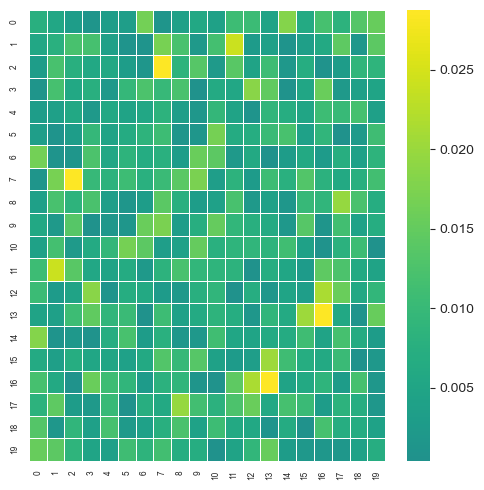

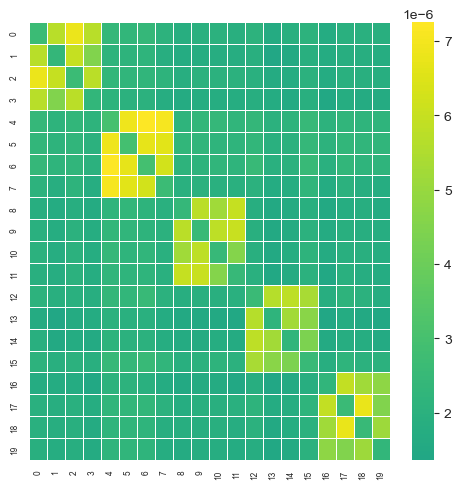

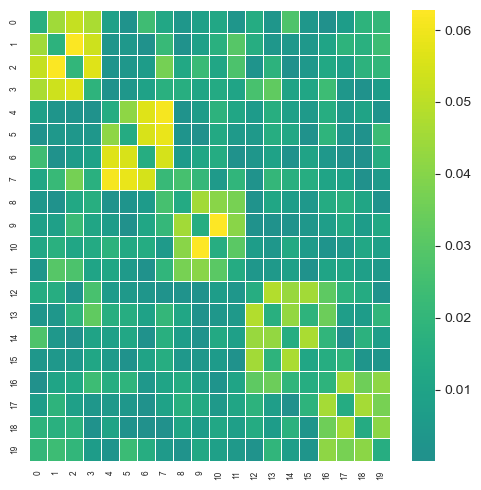

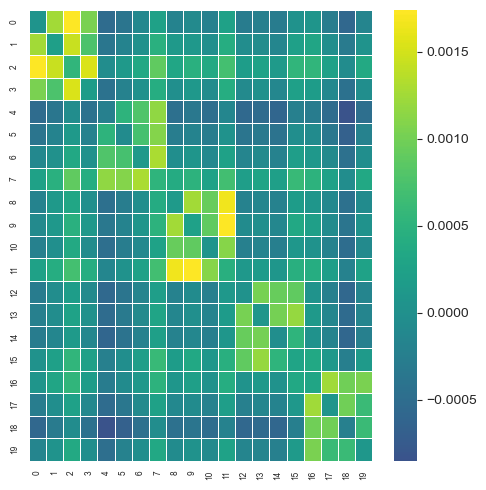

In [57]:
utils.show_matrix_with_colours(presence_table, fig_size=(5, 5))
utils.show_matrix_with_colours(H_squared_table, fig_size=(5, 5))
utils.show_matrix_with_colours(survival_table, fig_size=(5, 5))
utils.show_matrix_with_colours(adjusted_table, fig_size=(5, 5))


Normalisation between 7.253033157721879e-06 and 1.3615946305820177e-06
Normalisation between 0.0017398537837905632 and -0.0008520829241414206


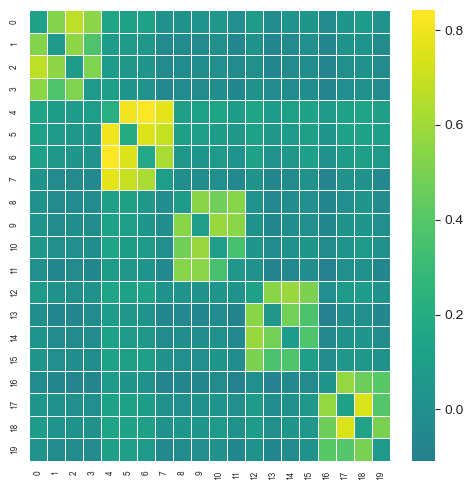

In [50]:
utils.show_matrix_with_colours(normalise_table(H_squared_table)-normalise_table(adjusted_table)*0.25, fig_size=(5, 5))

Normalisation between 12.0 and 0.0


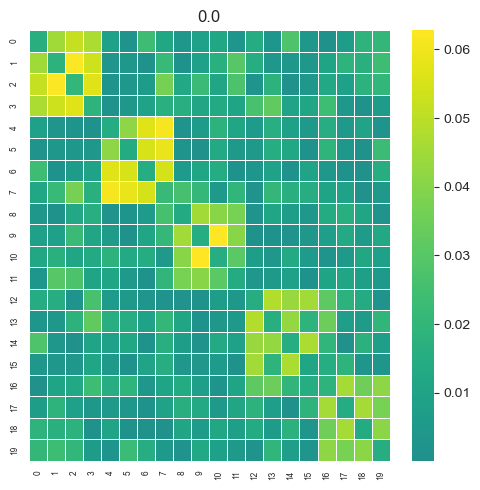

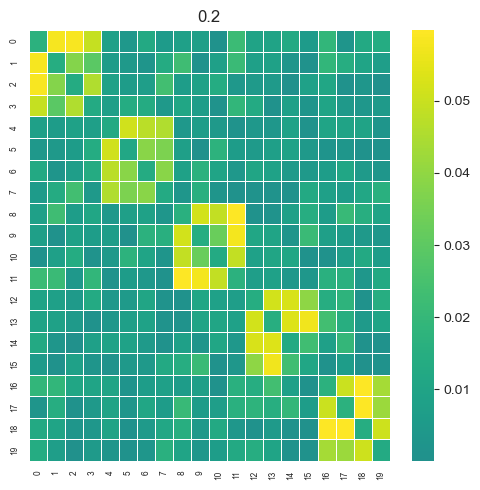

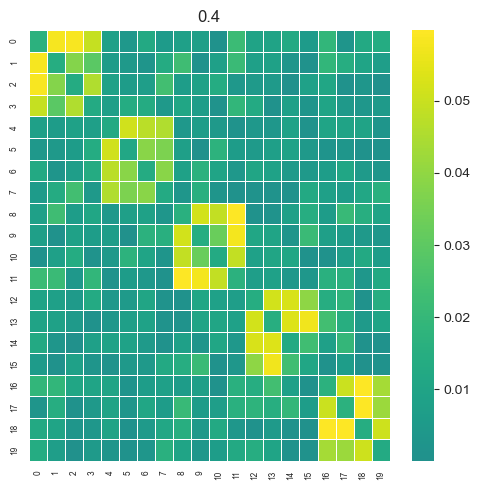

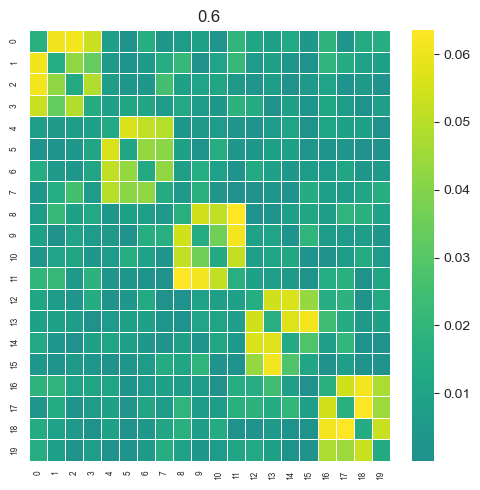

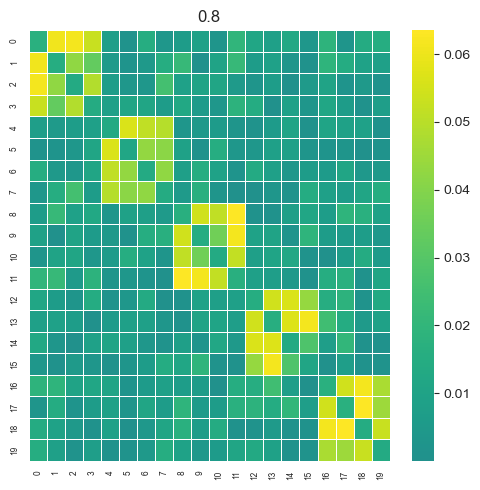

C:\Users\gac8\AppData\Local\Temp\ipykernel_16800\1813018431.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return abs(x-center)/(1-center)


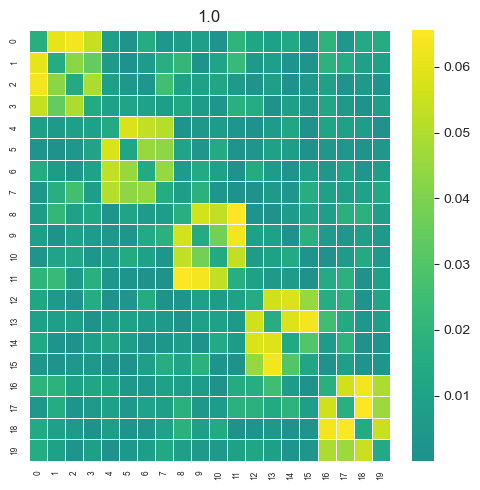

In [58]:
normal_fits = normalise_table(pRef.fitness_array)
stops = 5
for center in np.arange(stops+1) / stops:
    def transform(x):
        if x<center:
            return abs(x-center)/center
        else:
            return abs(x-center)/(1-center)
        
    new_fits = np.array([transform(x) for x in normal_fits])
    new_pRef = PRef(fitness_array=new_fits, full_solution_matrix=pRef.full_solution_matrix, search_space=pRef.search_space)
    temp_survival_table = get_linkage_table_from_dicts(get_survival_counts, new_pRef)
    utils.show_matrix_with_colours(temp_survival_table, fig_size=(5, 5), name=f"{center}")



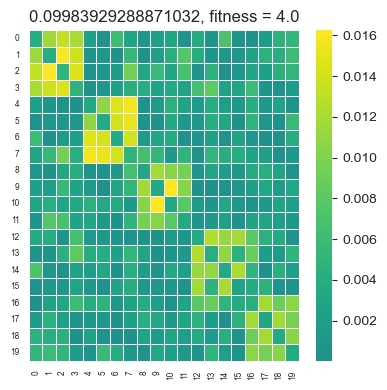

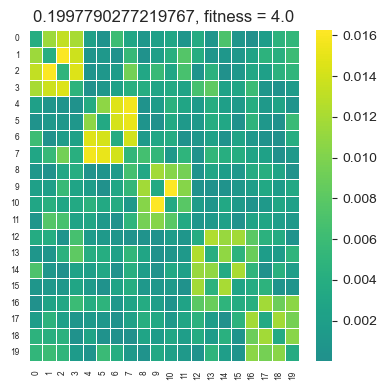

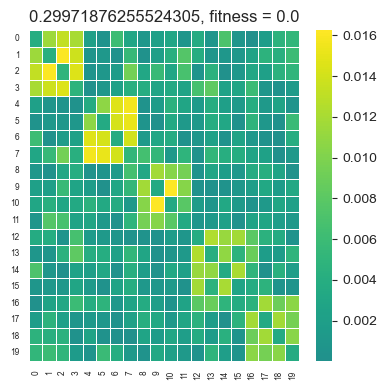

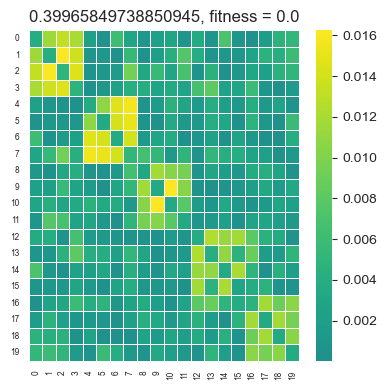

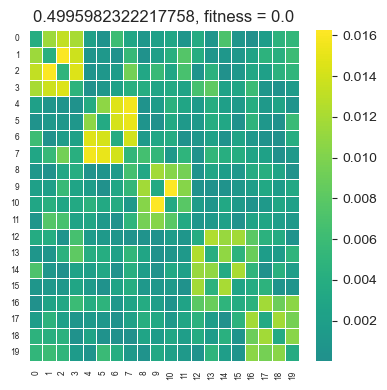

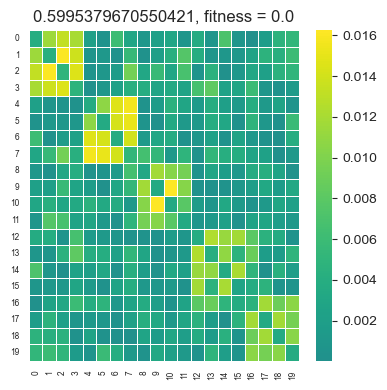

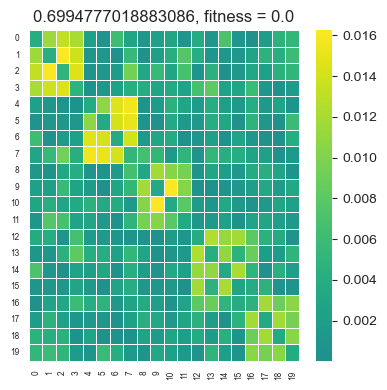

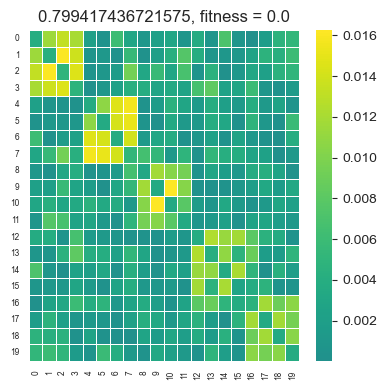

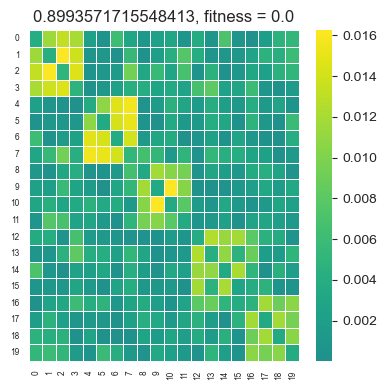

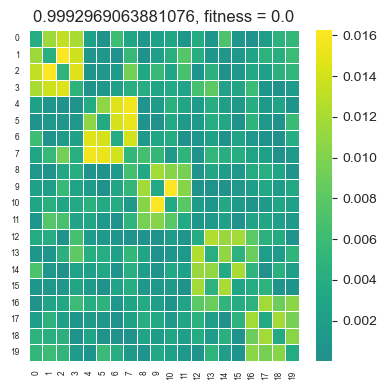

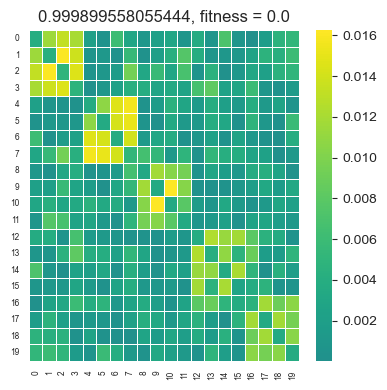

In [59]:
univariate_counts, bivariate_counts = get_survival_counts(pRef)

univariate_freqs, bivariate_freqs = normalise_dicts(univariate_counts, bivariate_counts, pRef.search_space)
presence_value_mis, presence_variable_mis = get_mutual_information_from_dicts(univariate_freqs, bivariate_freqs, search_space=pRef.search_space)


total_linkage_table = np.zeros(shape=(len(best_solution), len(best_solution)))
stops = 10
every = pRef.sample_size // stops
q = pRef.sample_size
for index, solution in enumerate(pRef.get_sorted(reverse=True).get_evaluated_FSs()):
    sol_linkage_table = linkage_table_from_mi_dict_for_solution(presence_value_mis, solution)
    total_linkage_table = np.maximum.reduce([total_linkage_table, sol_linkage_table])
    if index % every == (every-1) or index == pRef.sample_size-1:
        utils.show_matrix_with_colours(total_linkage_table, fig_size=(4,4), name=f"{index / pRef.sample_size}, fitness = {solution.fitness}")

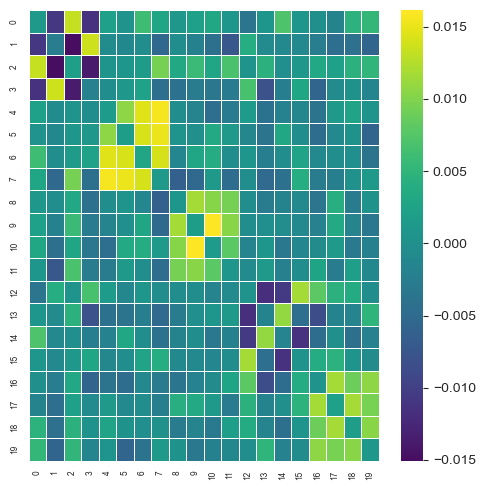

In [53]:
utils.show_matrix_with_colours(get_linkage_table_from_dicts(get_survival_counts, pRef, solution=best_solution), fig_size=(5,5))


